In [16]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.utils.random import sample_without_replacement

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# small parameter overview



**accousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.


**energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.


**instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.


**key**: The key the track is in. Integers map to pitches using standard Pitch Class notation.


**liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.


**loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.


**mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.


**speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

[source](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-analysis/)

**task**: predict popularity of a song (regression) based solely on other features/characterics of the music track

- impact of the artist's name on the popularity seems quiet obvious but also quiet a complex task (high cardinality data involving of processing to do), so I ll drop this parameter
    - also see quiet fun to primarily focus parameters charcterizing the music track itself
- **production year** and **release date** are in most case very near by another (at least at the year resolution), so I ll drop the release date

In [212]:
df = pd.read_csv('./archive/data.csv')
df.drop(['release_date', 'name', 'artists'], axis=1, inplace=True)

In [213]:
df.describe()

valence           year   acousticness   danceability  \
count  170653.000000  170653.000000  170653.000000  170653.000000   
mean        0.528587    1976.787241       0.502115       0.537396   
std         0.263171      25.917853       0.376032       0.176138   
min         0.000000    1921.000000       0.000000       0.000000   
25%         0.317000    1956.000000       0.102000       0.415000   
50%         0.540000    1977.000000       0.516000       0.548000   
75%         0.747000    1999.000000       0.893000       0.668000   
max         1.000000    2020.000000       0.996000       0.988000   

        duration_ms         energy       explicit  instrumentalness  \
count  1.706530e+05  170653.000000  170653.000000     170653.000000   
mean   2.309483e+05       0.482389       0.084575          0.167010   
std    1.261184e+05       0.267646       0.278249          0.313475   
min    5.108000e+03       0.000000       0.000000          0.000000   
25%    1.698270e+05       0.255000       0.000000          0.000000   
50%    2.074670e+05       0.471000       0.000000          0.000216   
75%    2.624000e+05       0.703000       0.000000          0.102000   
max    5.403500e+06       1.000000       1.000000          1.000000   

                 key       liveness       loudness           mode  \
count  170653.000000  170653.000000  170653.000000  170653.000000   
mean        5.199844       0.205839     -11.467990       0.706902   
std         3.515094       0.174805       5.697943       0.455184   
min         0.000000       0.000000     -60.000000       0.000000   
25%         2.000000       0.098800     -14.615000       0.000000   
50%         5.000000       0.136000     -10.580000       1.000000   
75%         8.000000       0.261000      -7.183000       1.000000   
max        11.000000       1.000000       3.855000       1.000000   

          popularity    speechiness          tempo  
count  170653.000000  170653.000000  170653.000000  
mean       31.431794       0.098393     116.861590  
std        21.826615       0.162740      30.708533  
min         0.000000       0.000000       0.000000  
25%        11.000000       0.034900      93.421000  
50%        33.000000       0.045000     114.729000  
75%        48.000000       0.075600     135.537000  
max       100.000000       0.970000     243.507000

In [19]:
pd.concat([df.nunique().rename('nunique'), df.isnull().sum().rename('nnull')], axis=1)

nunique  nnull
valence              1733      0
year                  100      0
acousticness         4689      0
danceability         1240      0
duration_ms         51755      0
energy               2332      0
explicit                2      0
id                 170653      0
instrumentalness     5401      0
key                    12      0
liveness             1740      0
loudness            25410      0
mode                    2      0
popularity            100      0
speechiness          1626      0
tempo               84694      0

# (spotify specific) music track characteristics

<AxesSubplot:>

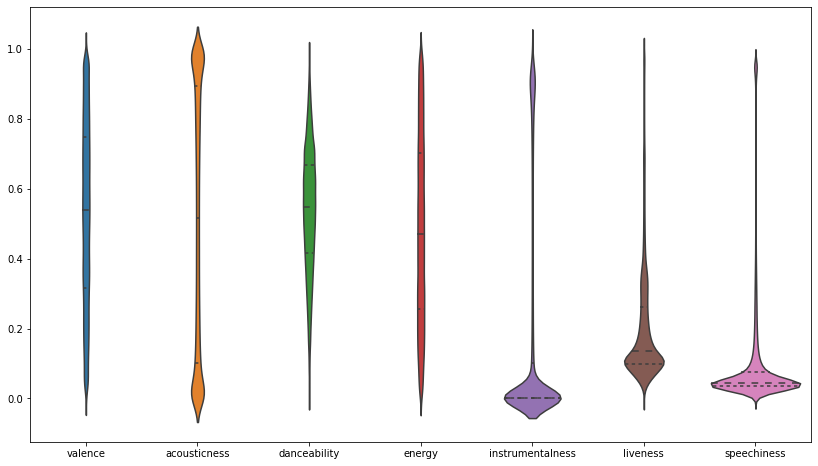

In [20]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
sns.violinplot(
    data=df.select_dtypes([int,float])
            .drop(
                [
                    'year', 'duration_ms', 
                    'loudness', 'popularity', 
                    'tempo', 'key', 'mode', 'explicit'
                ],
                axis=1
            ),
    inner='quartile',
    ax=ax,
)

<AxesSubplot:>

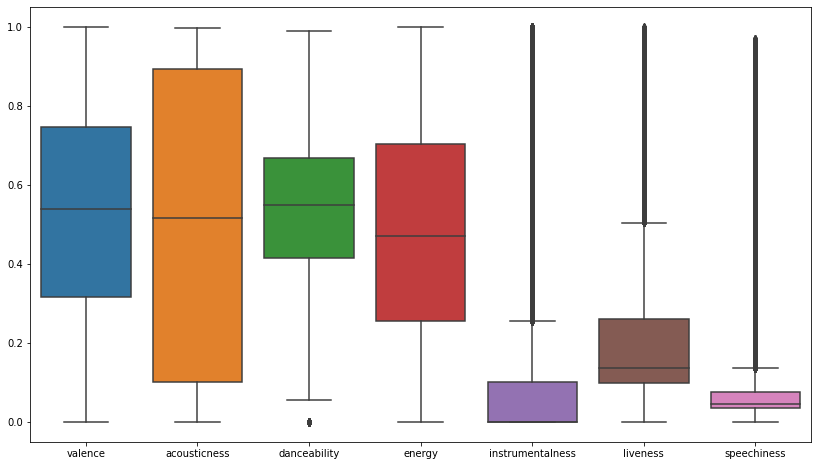

In [21]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
sns.boxplot(
    data=df.select_dtypes([int,float])
            .drop(
                [
                    'year', 'duration_ms', 
                    'loudness', 'popularity', 
                    'tempo', 'key', 'mode', 'explicit'
                ],
                axis=1
            ),
    ax=ax,
)

the characteric "features" of track provided by spotify with (0,1)-range exhibit very strange and mostly highly non-normal distributions.

**instrumentation,speechness,liveness**
- both show highly skewed distribution (heavy right tailed narrow "gaussian")
- hint of superposition (small bumps in right corners)
- instrumentation and speechness have a very similar shape

**danceability**
- very flat symmetric and centered distribution (0.5)

**valence,energy**
- almost uniform distribution with 
    
**acousticness**
- feels like binary entity with two buldges occuring on both ends of the distribution
- otherwise very flat
- median and mean have no meaning

unfortunetly I do not have enough computer resource to perform a full bivariate investigation 
(even with random subsampling)

# other predictors + target

In [22]:
import matplotlib.pyplot as plt

In [23]:
sample_size = 5000
idx = sample_without_replacement(df.shape[0], sample_size)

base = alt.Chart(df.iloc[idx]).mark_bar()
fig = alt.vconcat()

val = {
    'continuous predictor': ['tempo', 'loudness', 'duration_ms', 'year'],
    'discrete predictor': ['key', 'mode', 'explicit'],
    'target': ['popularity'],
}
for p, cols in val.items():
    row = alt.hconcat(title=p)
    for c in cols:
        row |= base.encode(
                alt.X(c, bin=alt.Bin(maxbins=50)),
                alt.Y('count():Q'),
                tooltip=['count():Q'],
            ).properties(
                title=c,
                width=200,
                height=500
        )
    fig &= row
fig

alt.VConcatChart(...)

- **popularity** the target has a very strange anomaly,i.e.
very large count in there lowest value 0

- maybe this value encode a different type of information? needs to be investigated -
  could not find any information in the [spotify api doc](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features)
  
- **tempo** shows a symmetric distribution centered around 120 bpm with a gap in the appr. range (0,30). music within this range probably doesn't exist. Tempo 0 could be podcasts or audiobooks or music with complex rythms/unclear tempo?

- **loudness** left skewed distribution 

- **duration_ms** seems to be poisson distributed (and not a truncated normal distribution)
     - makes sense since poisson distribution express "the probabilty of event occuring in specified interval with a known constant mean rate and independent of other events" wikipedia
     
- **year** almost uniformly distributed with a drastic drop occuring around the 1940s

# anomaly investigation

## bivariate scatterplots/KDEs and univariate KDEs for popularity == 0 

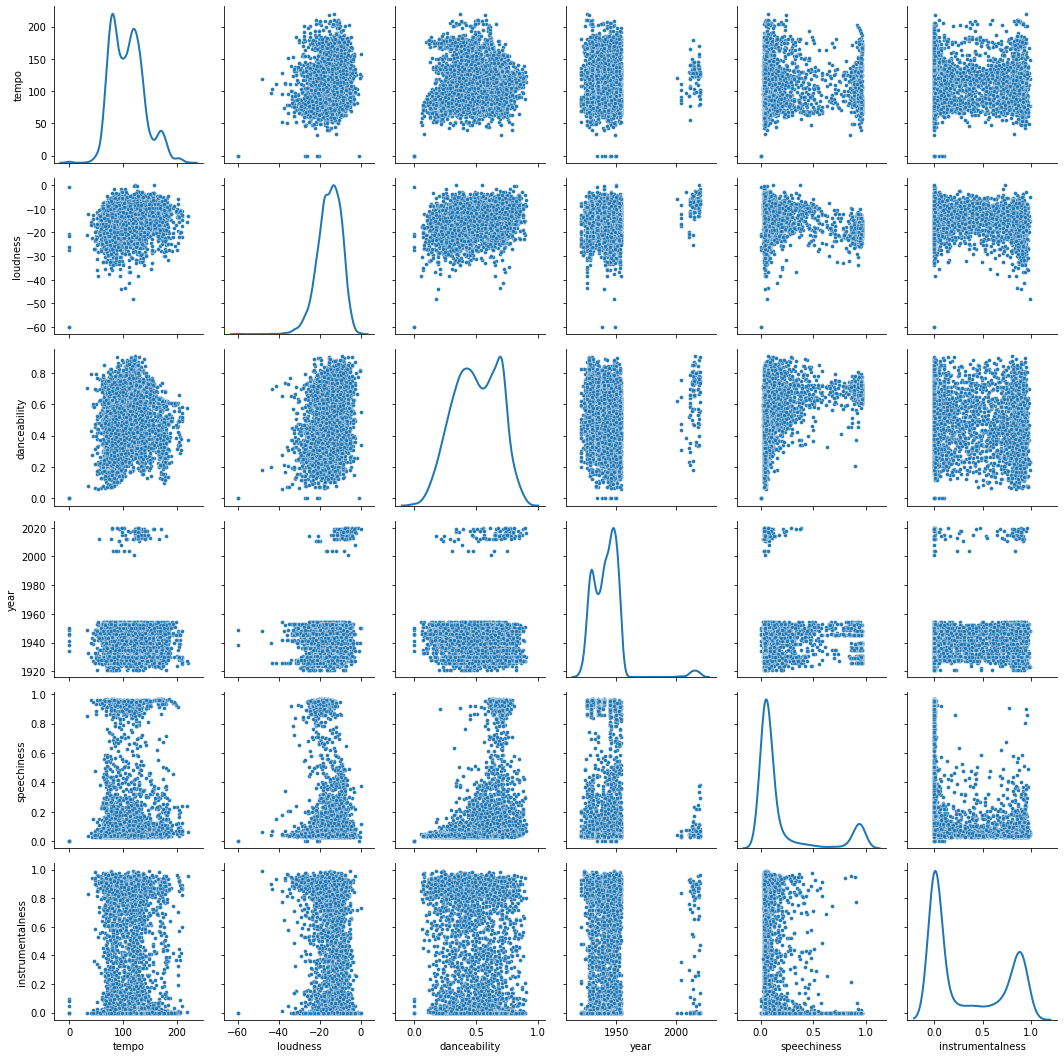

In [180]:
 data = (
     df.where(lambda r: r.popularity == 0)
      .dropna()
      .loc[:,['tempo', 'loudness', 'danceability', 'year', 'speechiness', 'instrumentalness']]
 )
    
sample_size = 5000
idx = sample_without_replacement(data.shape[0], sample_size)

g = sns.PairGrid(data.iloc[idx],diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

## bivariate scatterplots/KDEs and univariate KDEs for popularity != 0 

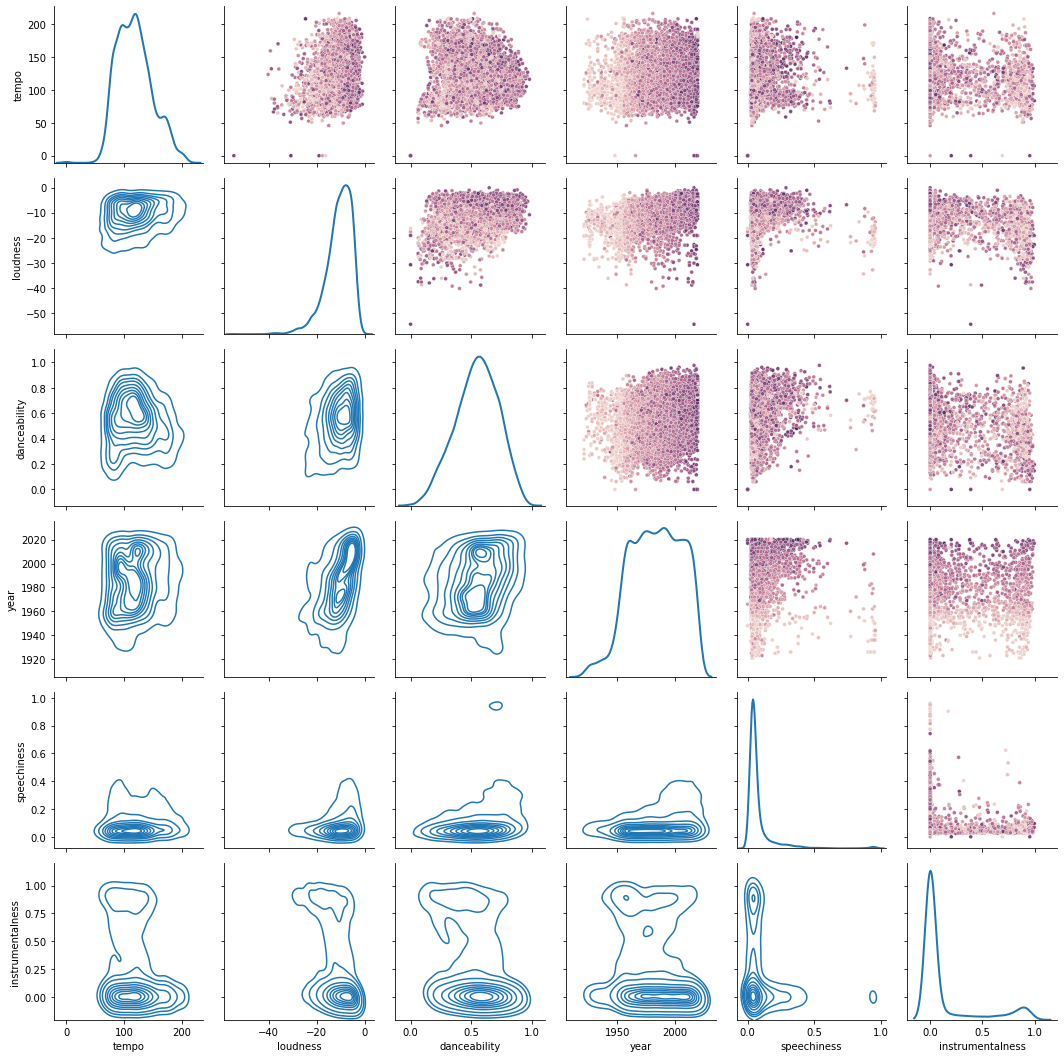

In [184]:
data = (
    df.where(lambda r: r.popularity != 0)
      .dropna()
      .loc[:,['tempo', 'loudness', 'danceability', 'year', 'popularity', 'speechiness', 'instrumentalness']]
)
sample_size = 5000
idx = sample_without_replacement(data.shape[0], sample_size)
g = sns.PairGrid(data.iloc[idx], hue='popularity', diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot, hue=None)
g.map_diag(sns.kdeplot, lw=2, hue=None)

<AxesSubplot:xlabel='year', ylabel='popularity'>

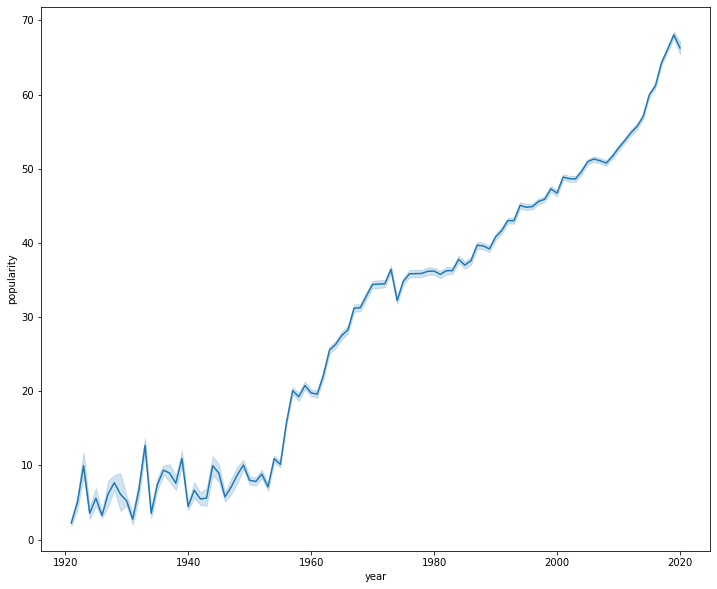

In [204]:
plt.subplots(1,1,figsize=(12,10))
sns.lineplot(data=df[df.popularity != 0], x='year', y='popularity', ci=95)

In [194]:
df

valence  year  acousticness  danceability  duration_ms  energy  \
0        0.0594  1921       0.98200         0.279       831667   0.211   
1        0.9630  1921       0.73200         0.819       180533   0.341   
2        0.0394  1921       0.96100         0.328       500062   0.166   
3        0.1650  1921       0.96700         0.275       210000   0.309   
4        0.2530  1921       0.95700         0.418       166693   0.193   
...         ...   ...           ...           ...          ...     ...   
170648   0.6080  2020       0.08460         0.786       301714   0.808   
170649   0.7340  2020       0.20600         0.717       150654   0.753   
170650   0.6370  2020       0.10100         0.634       211280   0.858   
170651   0.1950  2020       0.00998         0.671       337147   0.623   
170652   0.6420  2020       0.13200         0.856       189507   0.721   

        explicit                      id  instrumentalness  key  liveness  \
0              0  4BJqT0PrAfrxzMOxytFOIz          0.878000   10    0.6650   
1              0  7xPhfUan2yNtyFG0cUWkt8          0.000000    7    0.1600   
2              0  1o6I8BglA6ylDMrIELygv1          0.913000    3    0.1010   
3              0  3ftBPsC5vPBKxYSee08FDH          0.000028    5    0.3810   
4              0  4d6HGyGT8e121BsdKmw9v6          0.000002    3    0.2290   
...          ...                     ...               ...  ...       ...   
170648         0  0KkIkfsLEJbrcIhYsCL7L5          0.000289    7    0.0822   
170649         0  0OStKKAuXlxA0fMH54Qs6E          0.000000    7    0.1010   
170650         0  4BZXVFYCb76Q0Klojq4piV          0.000009    4    0.2580   
170651         1  5SiZJoLXp3WOl3J4C8IK0d          0.000008    2    0.6430   
170652         1  7HmnJHfs0BkFzX4x8j0hkl          0.004710    7    0.1820   

        loudness  mode  popularity  speechiness    tempo  
0        -20.096     1           4       0.0366   80.954  
1        -12.441     1           5       0.4150   60.936  
2        -14.850     1           5       0.0339  110.339  
3         -9.316     1           3       0.0354  100.109  
4        -10.096     1           2       0.0380  101.665  
...          ...   ...         ...          ...      ...  
170648    -3.702     1          72       0.0881  105.029  
170649    -6.020     1          68       0.0605  137.936  
170650    -2.226     0          76       0.0809   91.688  
170651    -7.161     1          70       0.3080   75.055  
170652    -4.928     1          74       0.1080   94.991  

[170653 rows x 16 columns]

In [26]:
df.where(lambda r: r.tempo == 0).dropna()

valence    year  acousticness  danceability  duration_ms    energy  \
508         0.0  1924.0       0.99600           0.0     133947.0  0.025800   
591         0.0  1924.0       0.99600           0.0     170253.0  0.315000   
2578        0.0  1934.0       0.00244           0.0      14629.0  0.801000   
2764        0.0  1935.0       0.93600           0.0     211880.0  0.202000   
3042        0.0  1937.0       0.89000           0.0     159600.0  0.281000   
...         ...     ...           ...           ...          ...       ...   
169591      0.0  2015.0       0.46900           0.0     153809.0  0.630000   
169717      0.0  2016.0       0.12700           0.0      93452.0  0.000062   
169935      0.0  2017.0       0.42000           0.0     180656.0  0.001720   
169968      0.0  2017.0       0.96200           0.0     175680.0  0.000020   
170187      0.0  2018.0       0.00212           0.0     304880.0  0.000020   

        explicit                      id  instrumentalness   key  liveness  \
508          0.0  2WTtJDfCUjAyCZHRSfCLDn           0.76800   5.0    0.0831   
591          0.0  5tQsQaMquCXBREb1FNymi7           0.95600   8.0    0.3750   
2578         0.0  29IVdlO7CSlcoOIpOsamkO           0.00125   4.0    0.0503   
2764         0.0  1QXbWUSsLWPtHrbZ7H8o9i           0.01370   6.0    0.1200   
3042         0.0  09eDRV4nzC3eVX7tDEJUNb           0.00000  10.0    0.2470   
...          ...                     ...               ...   ...       ...   
169591       1.0  00CutyaH2ljgLtM0nM5LLd           0.37500   2.0    0.1270   
169717       0.0  6HMSnRW8Htfd3YxdNgUF73           0.99900   9.0    0.7180   
169935       0.0  03sJaTenPLeRaVUISW6pI5           0.39900   4.0    0.1100   
169968       0.0  4UYLGTJRGCt4KzP9r9Y9bH           0.02800  11.0    0.1370   
170187       0.0  6bW6GIaja5aIc8CEjwTL5N           0.90500   1.0    0.4290   

        loudness  mode  popularity  speechiness  tempo  
508      -24.894   1.0         0.0          0.0    0.0  
591      -15.969   0.0         0.0          0.0    0.0  
2578      -0.671   0.0         0.0          0.0    0.0  
2764     -12.399   1.0         4.0          0.0    0.0  
3042     -13.078   1.0        17.0          0.0    0.0  
...          ...   ...         ...          ...    ...  
169591    -6.707   1.0        52.0          0.0    0.0  
169717   -18.685   1.0        54.0          0.0    0.0  
169935   -27.848   0.0        61.0          0.0    0.0  
169968   -52.220   0.0        57.0          0.0    0.0  
170187   -18.756   1.0        60.0          0.0    0.0  

[143 rows x 16 columns]

In [27]:
alt.Chart(
    (
        df.iloc[idx].where(lambda r: r.popularity == 0).groupby('year').agg({'id': 'count'}) / 
        df.iloc[idx].groupby('year').agg({'id': 'count'})
    ).fillna(value=0).reset_index().rename(columns={'id': 'percentile'})
).mark_bar().encode(
    x='year',
    y='percentile',
).properties(title='percentile zero popularity', width=600, height=400)

alt.Chart(...)

In [28]:
df.iloc[idx].where(lambda r: r.popularity == 0).groupby('year').size()
row = alt.hconcat()
base = (
    alt.Chart(df.iloc[idx])
        .mark_bar()
        .encode(x='year', y='count():Q', tooltip='year')
)
row |= (
    base
        .transform_filter(alt.datum.popularity == 0)
        .properties(width=600, height=500, title='track count with zero popularity vs year')
)
row |= (
    base
        .transform_filter(alt.datum.popularity != 0)
        .properties(width=600, height=500, title='track count with nonzero popularity vs year')
)
row |= (
    base
        #.transform_filter(alt.datum.popularity != 0)
        .properties(width=600, height=500, title='track count with nonzero popularity vs year')
)
row

alt.HConcatChart(...)

In [29]:
row = alt.vconcat()
row &= (
alt.Chart(df.iloc[idx])
    .mark_bar()
    .encode(x='year', y='mean(popularity):Q', tooltip=['year'])
    .properties(width=800, height=400)   
)
row &= (
alt.Chart(df.iloc[idx])
    .mark_bar()
    .encode(x='year', y='median(popularity):Q', tooltip=['year'])
    .properties(width=800, height=400)   
)
row

alt.VConcatChart(...)

In [424]:
from sklearn.utils.random import sample_without_replacement

X = df.select_dtypes([int,float]).values
cols = df.select_dtypes([int, float]).columns
N = X.shape[0]
#idx = sample_without_replacement(N, 0.5*N) 


In [425]:
corrX = np.corrcoef(X.T)

In [433]:
df.corr().style.background_gradient(cmap='coolwarm')

In [427]:
import plotly.express as px

px.imshow(
    pd.DataFrame(
        df.cov(), columns=list(cols)
    ),
    y=list(cols),
    color_continuous_scale='Viridis'
)

# covariance matrix insights gain

**Directly visible effects on popularity(target variable)**

- popularity of tracks strongly depends on the year the music track was produced
- positive corr indicates that a trend in increasing popularity with increasing year 
    - the more recent the track is the more popular it is / modern music is popular
- loudness and energy seems also to have positive effect on popularity
- whereas acousticness seems to have a negative impact on popularity
- unexpectedly both instrumentalness and danceability exhibit relatively low corr.
 
(however we should not forget that covariance solely captures the tendency in linear rel.)
   
**Correlation between predictors**

- there seems to be a strong correlation between loudness, energy and acousticness
- since energetic tracks "feel fast, **loud**, and noisy" this leads to an obvious
  connection between loudness and energy
- to my knowledge the majority of acoustic songs are not known to 'energetic and loud'
  (with exception of crazy classical music)
 

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
alt.data_transformers.disable_max_rows()
base = alt.Chart(
    pd.DataFrame({
        'x': np.arange(y_test.shape[0]),
        'y_test': y_test,
        'y_pred': y_pred,
    })
).mark_point()

base.encode(alt.X('x'), alt.Y('y_test'))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import graphviz
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2)
clf.fit(df.year.values.reshape(-1,1), df.popularity.values)

fig = plt.figure(figsize=(18,12))
_ = tree.plot_tree(clf, filled=True)

In [218]:
df['has_popularity'] = (df.popularity != 0).astype(int)

In [392]:
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, cross_validate, KFold
)
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

X = df.drop(['popularity', 'has_popularity', 'id'], axis=1)
y = df.has_popularity

X_train, X_test, y_train, y_test = (
    train_test_split(X,y, test_size=0.3, random_state=7)
)
dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)

# logistic regression

In [396]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
import sklearn.preprocessing as prep
#from sklearn.preprocessing import FunctionTransformer

preprocessor = ColumnTransformer([
    ('key', prep.OneHotEncoder(handle_unknown='ignore', dtype=int), ['key']),
    ('year', prep.MinMaxScaler(), ['year']),
    (
        'loudness', 
        make_pipeline(
            prep.FunctionTransformer(func=lambda x: np.log(np.abs(x))),
            prep.StandardScaler()
        ),
        ['loudness'],
    ),
    (
        'duration_ms', 
        make_pipeline(
            prep.FunctionTransformer(np.log),
            prep.StandardScaler(),
        ),
        ['duration_ms'],
    ),
    ('tempo', prep.StandardScaler(), ['tempo']),
    
], remainder='passthrough')

clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regress', LogisticRegression(max_iter=150))
])

scores = cross_validate(
    clf,
    X_train,
    y_train,
    scoring=['accuracy', 'f1', 'precision', 'recall'],
    cv=5
)
scores

{'fit_time': array([0.53333616, 0.76822805, 0.71651721, 0.7200532 , 0.70051789]),
 'score_time': array([0.05468893, 0.03533387, 0.03646207, 0.03579187, 0.03531122]),
 'test_accuracy': array([0.91369496, 0.90913276, 0.91532376, 0.91130551, 0.91034281]),
 'test_f1': array([0.9490134 , 0.94621578, 0.94990218, 0.94745456, 0.94698545]),
 'test_precision': array([0.9384322 , 0.9374141 , 0.94070041, 0.93951018, 0.9372428 ]),
 'test_recall': array([0.95983594, 0.95518431, 0.95928575, 0.95553444, 0.95693277])}

# xgboost classifier

In [221]:
params = {}
num_boost_round = 999
min_mae = float("Inf")
best_params = None
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgboost.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'logloss'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tlogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_mae:
        min_mae = mean_logloss
        best_params = (max_depth,min_child_weight)


CV with max_depth=9, min_child_weight=5
	logloss 0.1359954 for 10 rounds
CV with max_depth=9, min_child_weight=6
	logloss 0.133583 for 10 rounds
CV with max_depth=9, min_child_weight=7
	logloss 0.1322486 for 11 rounds
CV with max_depth=10, min_child_weight=5
	logloss 0.1387476 for 10 rounds
CV with max_depth=10, min_child_weight=6
	logloss 0.1380158 for 10 rounds
CV with max_depth=10, min_child_weight=7
	logloss 0.1383528 for 9 rounds
CV with max_depth=11, min_child_weight=5
	logloss 0.147751 for 8 rounds
CV with max_depth=11, min_child_weight=6
	logloss 0.1463238 for 10 rounds
CV with max_depth=11, min_child_weight=7
	logloss 0.14648339999999999 for 9 rounds


In [222]:
params = dict(zip(('max_depth', 'min_child_weight'), best_params))

In [223]:
params['eval_metric'] = 'logloss'
model = xgboost.train(params, dtrain)
y_pred = model.predict(dtest)

In [224]:
fpr, tpr, thr = roc_curve(y_test, y_pred)

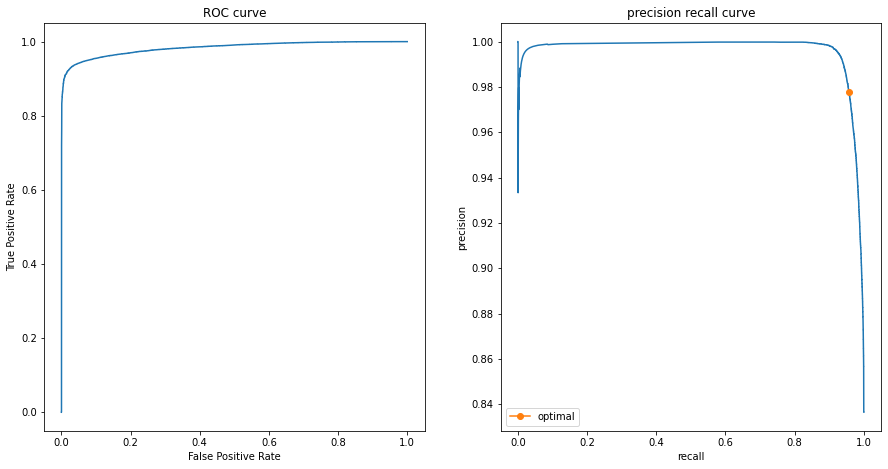

In [232]:
fig, ax = plt.subplots(1,2, figsize=(15,7.5))
ax1, ax2 = ax
ax1.plot(fpr, tpr)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC curve')

prec, rec, thr = precision_recall_curve(y_test, y_pred)
idx = np.argmax((2 *  rec * prec) / (prec + rec))
ax2.plot(rec, prec)
ax2.plot(rec[idx], prec[idx], marker='o', label='optimal')
ax2.set_xlabel('recall')
ax2.set_ylabel('precision')
ax2.set_title('precision recall curve')
plt.legend()

In [236]:
print('roc auc score {:.3f} with threshold {:.3f}'.format(roc_auc_score(y_test, y_pred), thr[idx]))

roc auc score 0.983 with threshold 0.490


In [246]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    recall_score,
    plot_confusion_matrix
)
print('accuracy_score: {:.3f} \nf1_score: {:.3f} \nrecall_score: {:.3f}'.format(
    accuracy_score(y_pred > thr[idx], y_test),
    f1_score(y_pred  > thr[idx],y_test),
    recall_score(y_pred  > thr[idx],y_test)
))
#plot_confusion_matrix(model, X_test, y_test, normalize='true')

accuracy_score: 0.946 
f1_score: 0.967 
recall_score: 0.978


In [239]:
confusion_matrix(y_pred > thr[idx], y_test),

(array([[ 7463,  1822],
        [  936, 40975]]),)

In [15]:
pd.DataFrame(
    {
        'features': X_train.columns, 
        'feature_importances': model.feature_importances_,
    }
).sort_values('feature_importances', ascending=False)

NameError: name 'X_train' is not defined

# Regression

## linear regression

In [442]:
X = df[df.has_popularity.astype(bool)].drop(
    [
        'popularity', 'has_popularity', 'id', 'year',
    ],
    axis=1,
)
y = df[df.has_popularity.astype(bool)].popularity

X_train, X_test, y_train, y_test = (
    train_test_split(X,y, test_size=0.3, random_state=7)
)

#model = xgboost.XGBRegessor()
dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)

In [463]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

preprocessor = ColumnTransformer([
    ('key', prep.OneHotEncoder(handle_unknown='ignore', dtype=int), ['key']),
    (
        'loudness', 
        make_pipeline(
            prep.FunctionTransformer(func=lambda x: np.log(np.abs(x))),
            prep.StandardScaler()
        ),
        ['loudness'],
    ),
    (
        'duration_ms', 
        make_pipeline(
            prep.FunctionTransformer(np.log),
            prep.StandardScaler(),
        ),
        ['duration_ms'],
    ),
    ('tempo', prep.StandardScaler(), ['tempo']),
    
], remainder='passthrough')

reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    (
        'regress', TransformedTargetRegressor(
            LinearRegression(),
            func=lambda x: x/100,
            inverse_func=lambda x: x*100,
        )
    ),
])
reg.fit(X_train, y_train)

NameError: name 'sklearn' is not defined

In [462]:
preprocessor.fit_tranform

AttributeError: 'ColumnTransformer' object has no attribute 'fit_tranform'

In [445]:
reg.score(X_train, y_train)

0.3398923175252653

In [446]:
cross_validate(
    reg, 
    X_train, 
    y_train,
    cv=5,
    scoring=[
        'max_error',
        'neg_mean_squared_error',
        'neg_median_absolute_error',
        'explained_variance'
    ],
)

{'fit_time': array([0.12770104, 0.12189198, 0.14272809, 0.12326908, 0.13170195]),
 'score_time': array([0.02137589, 0.01848698, 0.01865387, 0.02234292, 0.021456  ]),
 'test_max_error': array([-70.14257812, -86.28100586, -59.77355194, -62.74328613,
        -69.25292969]),
 'test_neg_mean_squared_error': array([-221.87783193, -223.01234353, -225.41341569, -224.53313608,
        -227.23100678]),
 'test_neg_median_absolute_error': array([-10.41259766, -10.546875  , -10.60919189, -10.44934082,
        -10.6652832 ]),
 'test_explained_variance': array([0.34445325, 0.34010558, 0.34060284, 0.33354043, 0.33900198])}

In [447]:
dict(zip(X_train.columns, reg['regress'].regressor_.coef_))

{'valence': 112577977601.77502,
 'acousticness': 112577977601.78473,
 'danceability': 112577977601.77626,
 'duration_ms': 112577977601.7671,
 'energy': 112577977601.7855,
 'explicit': 112577977601.77118,
 'instrumentalness': 112577977601.79387,
 'key': 112577977601.77498,
 'liveness': 112577977601.77348,
 'loudness': 112577977601.77731,
 'mode': 112577977601.77249,
 'speechiness': 112577977601.7848,
 'tempo': -0.04502629436833922}

In [ ]:
params = {}
num_boost_round = 999
min_rmse = float("Inf")
best_params = None
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgboost.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)

In [150]:
cv_results

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          18.039494        0.119690       18.042955       0.066079
1          17.380207        0.091928       17.381413       0.072629
2          17.012720        0.092904       17.012992       0.108516
3          16.737376        0.092508       16.736336       0.117058
4          16.521617        0.088400       16.521136       0.123672
..               ...             ...             ...            ...
994        14.844775        0.016823       14.848231       0.048518
995        14.844594        0.016822       14.848063       0.048506
996        14.844421        0.016839       14.847883       0.048462
997        14.844254        0.016826       14.847734       0.048474
998        14.844094        0.016835       14.847552       0.048476

[999 rows x 4 columns]

In [ ]:
params = dict(zip(('max_depth', 'min_child_weight'), best_params))

In [120]:
params['eval_metric'] = 'rmse'
model = xgboost.train(params, dtrain)
y_pred = model.predict(dtrain)

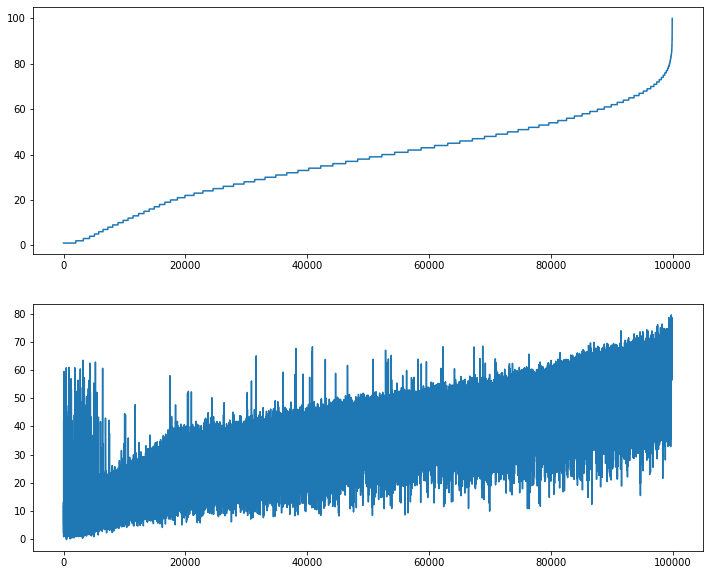

In [133]:
idx = np.argsort(dtrain.get_label())
fig, ax = plt.subplots(2,1, figsize=(12,10))
ax1, ax2 = ax
ax1.plot(dtrain.get_label()[idx])
ax2.plot(y_pred[idx])

In [137]:
model.get_score(importance_type='gain')

{'year': 83597.77957612129,
 'speechiness': 558.3527446306966,
 'danceability': 547.4364089183904,
 'duration_ms': 698.5987020257511,
 'energy': 491.62466368978045,
 'valence': 493.42332036063794,
 'loudness': 589.5659602194225,
 'liveness': 558.464681424456,
 'tempo': 550.539984893611,
 'instrumentalness': 628.8757702194633,
 'acousticness': 532.8625235829874,
 'key': 382.77785778377506,
 'explicit': 897.6923493225806,
 'mode': 350.48404116052467}

(array([5.7730e+03, 4.0080e+03, 4.2780e+03, 4.6300e+03, 7.5210e+03,
        8.6350e+03, 9.3620e+03, 1.0151e+04, 1.0707e+04, 9.5620e+03,
        7.9490e+03, 6.1920e+03, 4.8850e+03, 3.2680e+03, 1.7780e+03,
        8.3600e+02, 2.9400e+02, 8.0000e+01, 1.9000e+01, 4.0000e+00]),
 array([  1.  ,   5.95,  10.9 ,  15.85,  20.8 ,  25.75,  30.7 ,  35.65,
         40.6 ,  45.55,  50.5 ,  55.45,  60.4 ,  65.35,  70.3 ,  75.25,
         80.2 ,  85.15,  90.1 ,  95.05, 100.  ], dtype=float32),
 <BarContainer object of 20 artists>)

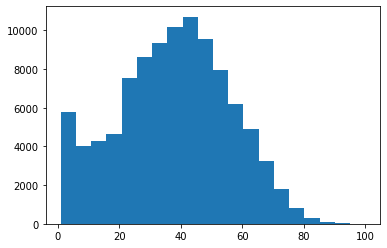

In [143]:
plt.hist(dtrain.get_label(), bins=20)

In [141]:
model.get_score(importance_type='cover')

{'year': 7115.723327305605,
 'speechiness': 854.9614906832298,
 'danceability': 862.577519379845,
 'duration_ms': 1091.0205714285714,
 'energy': 600.282119205298,
 'valence': 593.0,
 'loudness': 1048.5688185140073,
 'liveness': 823.54,
 'tempo': 618.5480519480519,
 'instrumentalness': 1029.582066869301,
 'acousticness': 651.958687727825,
 'key': 341.5014245014245,
 'explicit': 892.1290322580645,
 'mode': 1058.311475409836}

In [157]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

num_features = X_train.shape[1]

model = keras.Sequential(
    [
        keras.Input(shape=(num_features,)),
        layers.Dense(2, activation='relu'),
        
    ]
)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandartScaler

def process(df):
    processed_df = df.copy()
    processed_df['log_duration_ms'] = df.duration_ms.apply(np.log)
    processed_df['log_loudness'] = df.loudness.apply(lambda x: np.log(np.abs(x)))
    processed_df = processed_df.join(
        pd.get_dummines(df.key, prefix='key')
    )
    
    
    
def normalize_features(df):
    norm_df = df.copy()
    MinMaxScaler().fit_transform(df.train)
    norm_df['year'] = 
    norm_df['log_duration_ms'] = StandartScaler.fit_transform()df.train.duration_ms.apply(np.log)

(array([2.2800e+02, 9.7200e+02, 5.4020e+03, 4.7054e+04, 3.9846e+04,
        5.5650e+03, 6.9600e+02, 1.1100e+02, 4.6000e+01, 1.2000e+01]),
 array([10.17857818, 10.71097611, 11.24337404, 11.77577196, 12.30816989,
        12.84056782, 13.37296574, 13.90536367, 14.4377616 , 14.97015952,
        15.50255745]),
 <BarContainer object of 10 artists>)

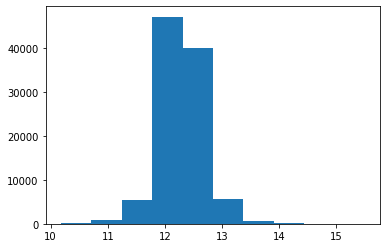

In [161]:
plt.hist(X_train.duration_ms.apply(np.log))

In [166]:
X_train

valence  year  acousticness  danceability  duration_ms  energy  \
52083     0.565  1994      0.006400         0.349       256000   0.575   
135902    0.983  1995      0.612000         0.864       173267   0.681   
118351    0.661  1987      0.000942         0.562       152107   0.721   
27643     0.589  1965      0.377000         0.431       249640   0.432   
83529     0.578  1976      0.507000         0.401       214893   0.825   
...         ...   ...           ...           ...          ...     ...   
82612     0.584  1971      0.984000         0.468        98307   0.176   
66274     0.796  1976      0.926000         0.519       274693   0.717   
12444     0.504  1984      0.124000         0.582       234493   0.606   
62504     0.265  1957      0.565000         0.475       334973   0.246   
74478     0.543  2017      0.179000         0.777       313053   0.957   

        explicit  instrumentalness  key  liveness  loudness  mode  \
52083          0          0.242000    5    0.1220   -12.029     1   
135902         0          0.288000    5    0.0563    -5.938     0   
118351         0          0.000173    0    0.1150   -11.413     1   
27643          0          0.000125    6    0.2780    -9.857     1   
83529          0          0.000055    2    0.3680    -6.488     1   
...          ...               ...  ...       ...       ...   ...   
82612          0          0.888000    0    0.0930   -13.043     1   
66274          0          0.700000    1    0.1590   -11.702     0   
12444          0          0.001390    6    0.1510    -9.961     1   
62504          0          0.000003    1    0.0909   -13.061     1   
74478          1          0.000000   11    0.2960    -3.201     0   

        speechiness    tempo  
52083        0.0546   97.236  
135902       0.0569  106.597  
118351       0.0498  119.704  
27643        0.0311   97.555  
83529        0.0451   99.304  
...             ...      ...  
82612        0.0401  124.741  
66274        0.0338  100.595  
12444        0.0289  111.441  
62504        0.0795  178.323  
74478        0.3190  105.756  

[99932 rows x 14 columns]

In [55]:
from sklearn.preprocessing import MinMaxScaler

def extract_features(df):
    df = df.select_dtypes([int,float]).copy()
    threshold_year = 1953.5
    df['year_below_1953'] = (df.year < threshold_year).astype(int)
    min_year, max_year = (
        threshold_year, df.year.max()
    )
    df['year'] = df['year'].apply(lambda y: (y - min_year) / (max_year - min_year))
    df.loc[df['year'] < 0, 'year'] = 0
    df['duration_ms'] = df['duration_ms'].apply(np.log)
    df['loudness'] = df['loudness'].apply(lambda x: np.log(np.abs(x)))
    df = df.join(
        pd.get_dummies(df.key, prefix='key')
    )
    df.drop(['key', 'duration_ms'], inplace=True, axis=1)
    return df
    

In [119]:
dtest.get_label()

array([40., 50., 39., ..., 63., 53., 49.], dtype=float32)

<AxesSubplot:>

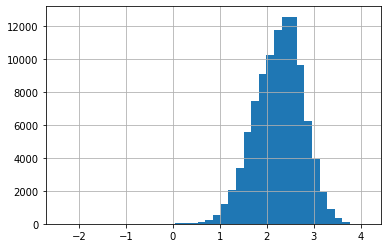

In [165]:
X_train.loudness.apply(lambda x: np.log(np.abs(x))).hist(bins=40)

In [79]:
from sklearn import linear_model

clf = linear_model.PoissonRegressor(max_iter=400)
features_df = features_df[features_df.popularity > 0]
X = features_df.drop('popularity', axis=1).values
Y = features_df.popularity
clf.fit(X,Y)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


PoissonRegressor(max_iter=400)

In [80]:
features_df.describe()

valence           year   acousticness   danceability  \
count  142761.000000  142761.000000  142761.000000  142761.000000   
mean        0.532026       0.463990       0.434115       0.544036   
std         0.262220       0.308364       0.356590       0.174606   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.321000       0.187970       0.070100       0.427000   
50%         0.540000       0.458647       0.384000       0.554000   
75%         0.750000       0.729323       0.789000       0.670000   
max         1.000000       1.000000       0.996000       0.988000   

              energy       explicit  instrumentalness       liveness  \
count  142761.000000  142761.000000     142761.000000  142761.000000   
mean        0.523557       0.083895          0.131680       0.202430   
std         0.262370       0.277232          0.282739       0.176639   
min         0.000000       0.000000          0.000000       0.000000   
25%         0.312000       0.000000          0.000000       0.095900   
50%         0.530000       0.000000          0.000093       0.131000   
75%         0.739000       0.000000          0.028900       0.254000   
max         1.000000       1.000000          1.000000       1.000000   

            loudness           mode  ...          key_2          key_3  \
count  142761.000000  142761.000000  ...  142761.000000  142761.000000   
mean        2.249372       0.709073  ...       0.111788       0.038939   
std         0.514748       0.454191  ...       0.315107       0.193451   
min        -4.961845       0.000000  ...       0.000000       0.000000   
25%         1.906575       0.000000  ...       0.000000       0.000000   
50%         2.286964       1.000000  ...       0.000000       0.000000   
75%         2.608451       1.000000  ...       0.000000       0.000000   
max         4.094345       1.000000  ...       1.000000       1.000000   

               key_4          key_5          key_6          key_7  \
count  142761.000000  142761.000000  142761.000000  142761.000000   
mean        0.076765       0.096063       0.049909       0.123423   
std         0.266219       0.294678       0.217757       0.328923   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

               key_8          key_9         key_10         key_11  
count  142761.000000  142761.000000  142761.000000  142761.000000  
mean        0.062314       0.106682       0.069956       0.061445  
std         0.241726       0.308709       0.255074       0.240146  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000       0.000000  
max         1.000000       1.000000       1.000000       1.000000  

[8 rows x 26 columns]

In [74]:
clf.score(X,Y)

0.6788194282969265

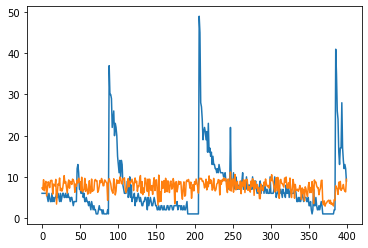

In [75]:
plt.plot(np.arange(400), Y[100:500])
plt.plot(np.arange(400), clf.predict(X[100:500]))

In [ ]:
clf = RandomForestClassifier()
cross_val_score(clf, X_train, y_train, cv=3)

In [27]:
dot_data = tree.export_graphviz(clf,out_file=None,feature_names=['year'],class_names=True)
graph = graphviz.Source(dot_data)
graph.render("image",view=True)
#f = open("./classifier.txt","w+")
#f.write(dot_data)
#f.close()

'image.pdf'

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.plot(y_test[:200])
plt.plot(y_pred[:200])

In [ ]:
pd.DataFrame({
    'f_importance': clf.feature_importances_,
    'feature': df.select_dtypes([int, float]).drop('popularity', axis=1).columns,
}).sort_values('f_importance', ascending=False)